# Poly8

This notebook was created to find the right parameters to work with *some* polynomials. All resulting polynomials will then be combined for training data in a deep learning model.

In [1]:
%%javascript 
// To get notebook's full path
var kernel = Jupyter.notebook.kernel; 
var command = ["notebookPath = ",
               "'", window.document.body.dataset.notebookPath, "'" ].join('')
//alert(command)
kernel.execute(command)
var command = ["notebookName = ",
               "'", window.document.body.dataset.notebookName, "'" ].join('')
//alert(command)
kernel.execute(command)

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import os, sys

dir_path = os.path.dirname(os.path.abspath(notebookName))

# Path to Computer root directory
ROOT_DIR = os.path.realpath(os.path.join(dir_path, '..', '..'))

sys.path.append(ROOT_DIR)
from libraries.helpers import configuration, prepare_initial_transformation, preprocess_line_finding, load_from
from libraries.find_lines_sliding_windows import FindLinesSlidingWindows
from libraries.line_helpers import annotate_with_lines

import pdb
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from ipywidgets import widgets, Checkbox, FloatSlider, IntSlider, IntRangeSlider, FloatRangeSlider, RadioButtons
from IPython.core.display import clear_output, display
import math

config = configuration()

TARGET_WIDTH = config['target_width']
TARGET_HEIGHT = config['target_height']
TARGET_CROP = config['target_crop']
STEER_MIN = config['steer_min']
STEER_MAX = config['steer_max']
CHANNELS = config['channels']
NORMALIZE = config['normalize']

# Set this to images directory
img_dir = "/home/jay/Self-Driving-RC-Data/recorded-2017-06-11-test"
# Set this to a .txt file that contains filenames.
img_paths = list(map(lambda x: os.path.join(img_dir, 'recorded', x), load_from(os.path.join(img_dir, 'poly8.txt'))))
# img_paths = glob.glob("/home/jay/Self-Driving-RC-Data/recorded-2017-06-11-test/recorded/*.jpg")

mtx, dist, M, Minv = prepare_initial_transformation(
    os.path.join(ROOT_DIR, 'calibrations', 'cal-elp.p'), TARGET_HEIGHT, TARGET_WIDTH)

Using TensorFlow backend.


((133, 0, 0), (255, 255, 255))


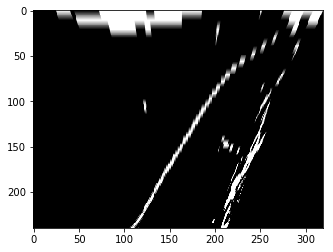

In [15]:
def find_color_hsv(change=None):
    inrange_min1 = inrange_min1_i.value
    inrange_min2 = inrange_min2_i.value
    inrange_min3 = inrange_min3_i.value
    inrange_max1 = inrange_max1_i.value
    inrange_max2 = inrange_max2_i.value
    inrange_max3 = inrange_max3_i.value
    
    img_path = img_paths[0]
    img_raw = cv2.imread(img_path)
    warped = preprocess_line_finding(img_raw, M, sobel=True, inrange=
                                     ((inrange_min1, inrange_min2, inrange_min3),
                                      (inrange_max1, inrange_max2, inrange_max3)))
    plt.imshow(warped, cmap='gray')  

    clear_output(True)
    print("(({}, {}, {}), ({}, {}, {}))".format(inrange_min1, inrange_min2, inrange_min3,
                                                inrange_max1, inrange_max2, inrange_max3))

inrange_min1_i = IntSlider(description='inrange min 1', min=0, max=255, step=1, value=133)
inrange_min2_i = IntSlider(description='inrange min 2', min=0, max=255, step=1, value=0)
inrange_min3_i = IntSlider(description='inrange min 3', min=0, max=255, step=1, value=0)
inrange_max1_i = IntSlider(description='inrange max 1', min=1, max=255, step=1, value=255)
inrange_max2_i = IntSlider(description='inrange max 2', min=1, max=255, step=1, value=255)
inrange_max3_i = IntSlider(description='inrange max 3', min=1, max=255, step=1, value=255)

inrange_min1_i.observe(find_color_hsv, 'value')
inrange_min2_i.observe(find_color_hsv, 'value')
inrange_min3_i.observe(find_color_hsv, 'value')
inrange_max1_i.observe(find_color_hsv, 'value')
inrange_max2_i.observe(find_color_hsv, 'value')
inrange_max3_i.observe(find_color_hsv, 'value')

display(inrange_min1_i, inrange_min2_i, inrange_min3_i,
        inrange_max1_i, inrange_max2_i, inrange_max3_i)
find_color_hsv()

/home/jay/Self-Driving-RC-Data/recorded-2017-06-11-test/recorded/2017-06-12_05-11-08.681301.jpg
line 1 error: 0.2869091963396249 (v)
line 1 coefs: [  1.05601033e-03   4.22203195e-01   1.14835618e+02]
line 2 error: 0.45094093796938645 (v)
line 2 coefs: [  1.41049141e-04   3.80817722e-01   2.07181591e+02]


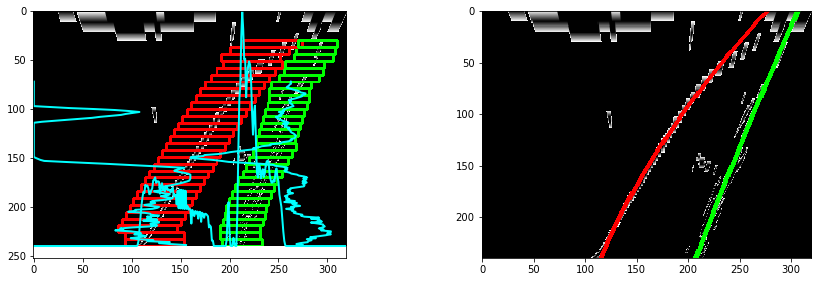

In [25]:
local_paths = img_paths[:]

i = 1
total = len(local_paths) * 2
cols = 2
fig = plt.figure(figsize=(15, (total/cols)*10))
for img_path in local_paths:
    print(img_path)
    a = fig.add_subplot((total/cols)+1, cols, i)
    img_raw = cv2.imread(img_path)
    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

    preprocessed = preprocess_line_finding(img_raw, M, inrange=((133, 0, 0), (255, 255, 255)))
    finder = FindLinesSlidingWindows(nwindows=30, window_minpix=2, left_search_margin=30, right_search_margin=20,
                                     v_win_crop_top=0.01, error_threshold=40, window_patience=8,
                                     window_empty_px=0, error_top_percentile=80, center_importance=0,
                                     closer_importance=2,lines=(1,0,1,0),
                                     debug_axes_for_histogram=a, debug=True, 
                                     debug_dir='v', debug_show_lines=False, debug_error_detail=False)

    fits = finder.process(preprocessed)

    final_img = annotate_with_lines(preprocessed, fits)
    
    i += 1
    a = fig.add_subplot((total/cols)+1, cols, i)
    plt.imshow(final_img, cmap='gray')
    i += 1

2017-06-12_05-11-08.681301.jpg


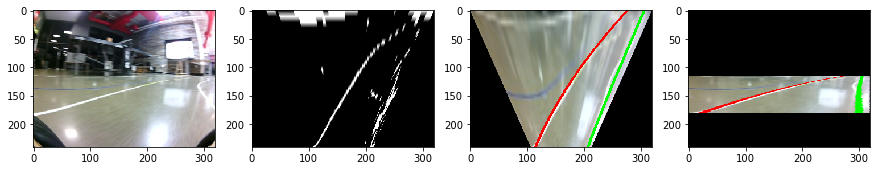

In [27]:
local_paths = img_paths[:]
i = 1
total = len(local_paths)*4
cols = 4
fig = plt.figure(figsize=(15, (total/cols)*10))
for img_path in local_paths:
    print(os.path.basename(img_path))
    img_raw = cv2.imread(img_path)
    img = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
    warped = cv2.warpPerspective(img, M, (TARGET_WIDTH, TARGET_HEIGHT))

    # Display the original, undistorted, and warped image
    a = fig.add_subplot((total/cols)+1, cols, i)
    plt.imshow(img)
    i+=1

    preprocessed = preprocess_line_finding(img_raw, M, inrange=((133, 0, 0), (255, 255, 255)))

    a = fig.add_subplot((total/cols)+1, cols, i)
    plt.imshow(preprocessed, cmap="gray")
    i+=1
    
    # Find lines
    a = fig.add_subplot((total/cols)+1, cols, i)
    finder = FindLinesSlidingWindows(nwindows=30, window_minpix=2, left_search_margin=30, right_search_margin=20,
                                     v_win_crop_top=0.01, error_threshold=40, window_patience=8,
                                     window_empty_px=0, error_top_percentile=80, center_importance=0,
                                     closer_importance=2,lines=(1,0,1,0))
    fits = finder.process(preprocessed)
    final_img = annotate_with_lines(warped, fits, keep_background=True)
    plt.imshow(final_img)
    i += 1
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    a = fig.add_subplot((total/cols)+1, cols, i)
    final_img = cv2.warpPerspective(final_img, Minv, (final_img.shape[1], final_img.shape[0]))
    plt.imshow(final_img)
    i += 1